In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
SEED = 777

In [4]:
def preproc(x):
#     x = x*2 - 1.0
    # per-example mean subtraction (http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing)
    mean = tf.reduce_mean(x, axis=1, keep_dims=True)
    return x - mean

In [5]:
class Solver:
    def __init__(self, sess, model):
        self.model = model
        self.sess = sess
        
    def train(self, X, y):
        feed = {
            self.model.X: X,
            self.model.y: y,
            self.model.training: True
        }
        train_op = self.model.train_op
        loss = self.model.loss
        
        return self.sess.run([train_op, loss], feed_dict=feed)
    
    def evaluate(self, X, y, batch_size=None):
        if batch_size:
            N = X.shape[0]
            
            total_loss = 0
            total_acc = 0
            
            for i in range(0, N, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                feed = {
                    self.model.X: X_batch,
                    self.model.y: y_batch,
                    self.model.training: False
                }
                
                loss = self.model.loss
                accuracy = self.model.accuracy
                
                step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed)
                
                total_loss += step_loss * X_batch.shape[0]
                total_acc += step_acc * X_batch.shape[0]
            
            total_loss /= N
            total_acc /= N
            
            return total_loss, total_acc
            
            
        else:
            feed = {
                self.model.X: X,
                self.model.y: y,
                self.model.training: False
            }
            
            loss = self.model.loss            
            accuracy = self.model.accuracy

            return self.sess.run([loss, accuracy], feed_dict=feed)
    
    # return: wrong_indices, predicted, 
    def wrong_indices(self, X, y, batch_size=None):
        N = X.shape[0]
        y_c = np.argmax(y, axis=1)
        pred_stack = np.empty(0, dtype='int32')
        if batch_size == None:
            batch_size = N
        for i in range(0, N, batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            feed = {
                self.model.X: X_batch,
                self.model.y: y_batch,
                self.model.training: False
            }
            
            pred = self.sess.run(self.model.pred, feed_dict=feed)
            pred_stack = np.hstack([pred_stack, pred])

#         print(pred_stack.shape)
#         print(y_c.shape)
        assert pred_stack.shape == y_c.shape

        return np.argwhere(np.equal(pred_stack, y_c) == False).T[0], pred_stack

In [12]:
class Model:
    def __init__(self, name, lr=0.001):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, [None, 784], name='X')
            self.y = tf.placeholder(tf.float32, [None, 10], name='y')
            self.training = tf.placeholder(tf.bool, name='training')
            
            x = preproc(self.X)
            x_img = tf.reshape(x, [-1, 28, 28, 1])

            # hidden layers
            net = x_img
            n_filters = 64
            for i in range(3):
                net = tf.layers.conv2d(net, n_filters, [3,3], strides=1, padding='SAME', use_bias=False,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=SEED))
                net = tf.layers.batch_normalization(net, training=self.training)
                net = tf.nn.relu(net)
                net = tf.layers.dropout(net, rate=0.3, training=self.training, seed=SEED)
                
                net = tf.layers.conv2d(net, n_filters, [5,5], strides=2, padding='SAME', use_bias=False,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=SEED))
#                 net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
                net = tf.layers.batch_normalization(net, training=self.training)
                net = tf.nn.relu(net)
                net = tf.layers.dropout(net, rate=0.3, training=self.training, seed=SEED)
                n_filters *= 2
            
            # x: [28, 28, 1]
            # h1: [14, 14, 64]
            # h2: [7, 7, 128]
            # h3: [4, 4, 256]
            # 4096 -> 1024 -> 10
            
            net = tf.contrib.layers.flatten(net)
#             net = tf.layers.dense(net, 1024, activation=tf.nn.relu)
#             net = tf.layers.dropout(net, rate=0.5, training=self.training)
            logits = tf.layers.dense(net, 10, weights_initializer=tf.contrib.layers.xavier_initializer(seed=SEED))
            
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
#             self.loss = tf.reduce_mean(tf.losses.hinge_loss(logits=logits, labels=self.y))
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=name)
            with tf.control_dependencies(update_ops):
                self.train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.loss)    
            
            self.pred = tf.argmax(logits, axis=1)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.pred, tf.argmax(self.y, axis=1)), tf.float32))

In [13]:
tf.reset_default_graph()

sess = tf.Session()

basic_cnn = Model('basic_cnn', lr=0.001)
solver = Solver(sess, basic_cnn)

tf.set_random_seed(SEED)
np.random.seed(SEED)

In [14]:
sess.run(tf.global_variables_initializer())

batch_size = 50
epoch_n = 30
N = mnist.train.num_examples

max_train_acc = 0
max_valid_acc = 0
max_test_acc = 0

for epoch in range(epoch_n):
    for _ in range(N // batch_size):
        batches = mnist.train.next_batch(batch_size)
        _, train_loss = solver.train(batches[0], batches[1])
#         sess.run(solver, {X: batches[0], y: batches[1]})
    
    train_loss, train_acc = solver.evaluate(mnist.train.images, mnist.train.labels, 1000)
    valid_loss, valid_acc = solver.evaluate(mnist.validation.images, mnist.validation.labels, 1000)
    test_loss, test_acc = solver.evaluate(mnist.test.images, mnist.test.labels, 1000)
    line = "[{:0>2d}/{}] train: {:.4f}, {:.3%} / valid: {:.4f}, {:.2%} / test: {:.4f}, {:.2%}". \
    format(epoch+1, epoch_n, train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc)
    print(line)
    
    if train_acc > max_train_acc:
        max_train_acc = train_acc
        train_line = line
    if valid_acc > max_valid_acc:
        max_valid_acc = valid_acc
        valid_line = line
    if test_acc > max_test_acc:
        max_test_acc = test_acc
        test_line = line
    

print("[train max] {}".format(train_line))
print("[valid max] {}".format(valid_line))
print("[ test max] {}".format(test_line))

[01/30] train: 0.0172, 97.673% / valid: 0.0165, 97.96% / test: 0.0153, 98.03%
[02/30] train: 0.0088, 98.865% / valid: 0.0097, 98.74% / test: 0.0087, 98.81%
[03/30] train: 0.0059, 99.165% / valid: 0.0076, 98.92% / test: 0.0073, 98.95%
[04/30] train: 0.0059, 99.191% / valid: 0.0081, 99.00% / test: 0.0063, 99.04%
[05/30] train: 0.0047, 99.355% / valid: 0.0068, 99.02% / test: 0.0057, 99.24%
[06/30] train: 0.0027, 99.625% / valid: 0.0050, 99.30% / test: 0.0039, 99.48%
[07/30] train: 0.0045, 99.313% / valid: 0.0067, 99.04% / test: 0.0068, 98.92%
[08/30] train: 0.0029, 99.575% / valid: 0.0049, 99.30% / test: 0.0047, 99.28%
[09/30] train: 0.0021, 99.722% / valid: 0.0039, 99.28% / test: 0.0038, 99.45%
[10/30] train: 0.0029, 99.589% / valid: 0.0062, 99.04% / test: 0.0050, 99.20%
[11/30] train: 0.0013, 99.825% / valid: 0.0044, 99.32% / test: 0.0036, 99.43%
[12/30] train: 0.0015, 99.800% / valid: 0.0045, 99.40% / test: 0.0041, 99.45%
[13/30] train: 0.0011, 99.825% / valid: 0.0039, 99.46% / test: 0

In [9]:
solver = Solver(sess, basic_cnn)
wrongs, predicted = solver.wrong_indices(mnist.test.images, mnist.test.labels, 1000)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot(images, labels, predicted):
    l = len(images)
    height = (l+9) // 10
    fig = plt.figure(figsize=(10,7))
    gs = gridspec.GridSpec(height,10)
    gs.update(wspace=0.05, hspace=0.05)
    corrects = np.argmax(labels, axis=1) # one-hot => single
    
    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_title("{} ({})".format(corrects[i], predicted[i]))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(28, 28), cmap='Greys')
    
    return fig

# plt.imshow(mnist.test.images[0].reshape(28, 28), cmap='Greys')
# plt.show()

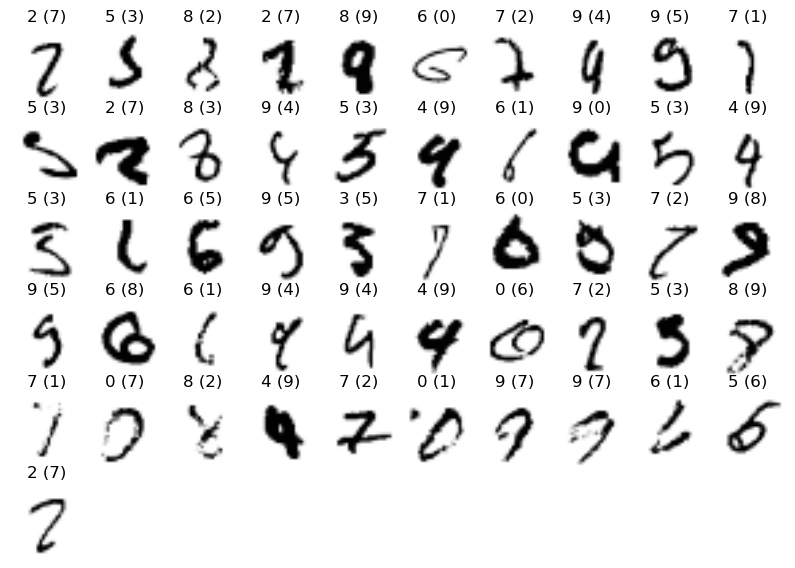

In [11]:
plot(mnist.test.images[wrongs], mnist.test.labels[wrongs], predicted[wrongs])

## Results

* basic-without preproc(zero-centered mean): 98.60%
* basic: 98.95%
* BN: 98.68%
    * BN-0.01: 94%
    * BN-0.05: 98.29%


* 2-strided models
    * BN: 99.26%
        * bias: 99.15%
    * No-BN, No-bias: 99.10%
    * No-BN: 99.26%
        * added 1 more 1024 dense layer: 99.00%
        * normalized input: 99.15%
* [(3,3),1] + [(5,5),2] model + BN
    * 2-FC + dropout: 99.39%, 99.46%
    * 1-FC: 99.52%, 99.49%
        * conv dropout 0.5: 99.53%
        * conv dropout 0.2: 99.45?
        * conv dropout 0.7: 99.11%, 99.35% (batch size 50)
        * conv dropout 0.3 + batch size 50 + epoch 30: 99.55%
            * [train max] [54/60] train: 0.0001, 99.998% / valid: 0.0287, 99.58% / test: 0.0225, 99.56%
            * [valid max] [25/60] train: 0.0018, 99.949% / valid: 0.0227, 99.62% / test: 0.0226, 99.53%
            * [ test max] [53/60] train: 0.0004, 99.989% / valid: 0.0292, 99.52% / test: 0.0263, 99.60%
* [(3,3),1] + [(3,3),2] model + BN
    * 1-FC
        * conv dropout 0.1: 99.41%
* max pooling 99.35%